In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BAM(nn.Module):
    def __init__(self, channels, reduction=16, dilation_val=4):
        super(BAM, self).__init__()
        # Channel Attention
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

        # Spatial Attention
        self.spatial_att = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.BatchNorm2d(channels // reduction),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels // reduction, kernel_size=3, padding=dilation_val, dilation=dilation_val, bias=False),
            nn.BatchNorm2d(channels // reduction),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, 1, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        ch_att = self.channel_att(x)
        sp_att = self.spatial_att(x)
        attention = 1 + ch_att * sp_att
        return x * attention


In [13]:
import timm
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os


class MobileViTv2_BAM(nn.Module):
    def __init__(self, num_classes):
        super(MobileViTv2_BAM, self).__init__()
        self.backbone = timm.create_model('mobilevitv2_050', pretrained=True, num_classes=num_classes)
        # You may need to adapt these channels after inspecting backbone output shapes
        self.bam1 = BAM(channels=64)
        self.bam2 = BAM(channels=128)

    def forward(self, x):
        # Example forward based on timm; may vary by architecture internals
        x = self.backbone.forward_features(x)
        # Optional: apply BAM modules here if you extract intermediate features
        x = self.backbone.head(x)
        return x


# === Dataset Preparation ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

base_path = '/home/itartoussi/.agml/datasets/dataset_occluded_tomato10'
train_dataset = datasets.ImageFolder(os.path.join(base_path, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(base_path, 'val'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes

# === Training Prep ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MobileViTv2_BAM(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# === Ready for Training Loop ===
print("✅ Model with BAM is ready for training.")


✅ Model with BAM is ready for training.


In [14]:
from sklearn.metrics import f1_score
import copy

num_epochs = 100
best_f1 = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    # --- Training ---
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = train_correct / total_train
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            total_val += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = val_correct / total_val
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")

    # --- Save Best Model ---
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_model_bam_mobilevitv2.pth")
        print(f"✅ Best model saved with F1 Score: {best_f1:.4f}")



Epoch 1/100
------------------------------


Train Loss: 674.2209, Accuracy: 0.7378
Val Loss: 106.8508, Accuracy: 0.9187, F1 Score: 0.9096
✅ Best model saved with F1 Score: 0.9096

Epoch 2/100
------------------------------
Train Loss: 125.1190, Accuracy: 0.9447
Val Loss: 22.4609, Accuracy: 0.9873, F1 Score: 0.9873
✅ Best model saved with F1 Score: 0.9873

Epoch 3/100
------------------------------
Train Loss: 58.2217, Accuracy: 0.9730
Val Loss: 9.7822, Accuracy: 0.9943, F1 Score: 0.9943
✅ Best model saved with F1 Score: 0.9943

Epoch 4/100
------------------------------
Train Loss: 39.0266, Accuracy: 0.9810
Val Loss: 6.1046, Accuracy: 0.9965, F1 Score: 0.9965
✅ Best model saved with F1 Score: 0.9965

Epoch 5/100
------------------------------
Train Loss: 27.3078, Accuracy: 0.9864
Val Loss: 3.7327, Accuracy: 0.9977, F1 Score: 0.9977
✅ Best model saved with F1 Score: 0.9977

Epoch 6/100
------------------------------
Train Loss: 18.8836, Accuracy: 0.9907
Val Loss: 2.3264, Accuracy: 0.9987, F1 Score: 0.9987
✅ Best model saved with 

/tmp/ipykernel_2628693/2496663131.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_bam_mobilevitv2.pth"))


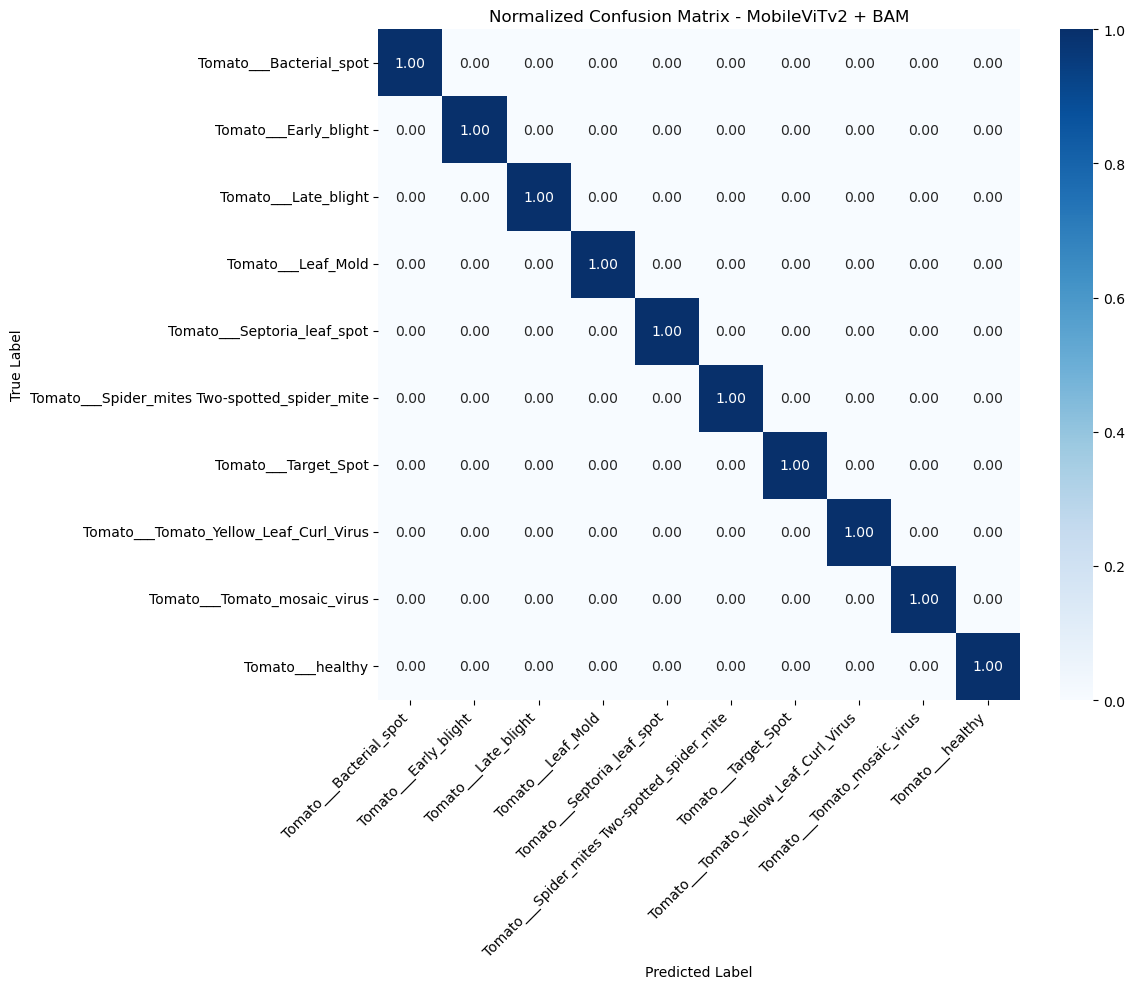

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Load best model weights (if not already loaded)
model.load_state_dict(torch.load("best_model_bam_mobilevitv2.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix - MobileViTv2 + BAM")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BAM(nn.Module):
    def __init__(self, channels, reduction=16, dilation_val=4):
        super(BAM, self).__init__()
        # Channel Attention
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

        # Spatial Attention
        self.spatial_att = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.BatchNorm2d(channels // reduction),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels // reduction, kernel_size=3, padding=dilation_val, dilation=dilation_val, bias=False),
            nn.BatchNorm2d(channels // reduction),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, 1, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        ch_att = self.channel_att(x)
        sp_att = self.spatial_att(x)
        attention = 1 + ch_att * sp_att
        return x * attention


In [5]:
import timm
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os


class MobileViTv2_BAM(nn.Module):
    def __init__(self, num_classes):
        super(MobileViTv2_BAM, self).__init__()
        self.backbone = timm.create_model('mobilevitv2_050', pretrained=True, num_classes=num_classes)
        # You may need to adapt these channels after inspecting backbone output shapes
        self.bam1 = BAM(channels=64)
        self.bam2 = BAM(channels=128)

    def forward(self, x):
        # Example forward based on timm; may vary by architecture internals
        x = self.backbone.forward_features(x)
        # Optional: apply BAM modules here if you extract intermediate features
        x = self.backbone.head(x)
        return x


# === Dataset Preparation ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

base_path = '/home/itartoussi/.agml/datasets/dataset_occluded_tomato10'
train_dataset = datasets.ImageFolder(os.path.join(base_path, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(base_path, 'val'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes

# === Training Prep ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MobileViTv2_BAM(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# === Ready for Training Loop ===
print("✅ Model with BAM is ready for training.")


✅ Model with BAM is ready for training.


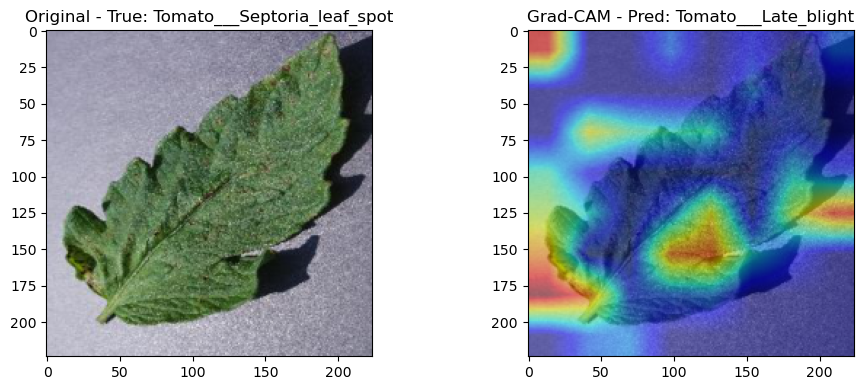

✅ Grad-CAM plot saved.


In [ ]:
from torchcam.methods import GradCAM
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import random
import numpy as np

target_layer = "backbone.final_conv"

model.train()

cam_extractor = GradCAM(model, target_layer=target_layer)

idx = random.randint(0, len(val_dataset) - 1)
img, label = val_dataset[idx]
input_tensor = img.unsqueeze(0).to(device)
input_tensor.requires_grad_()  # 🔴 ضروري لتفعيل التدرجات


output = model(input_tensor)
pred_class = output.argmax(dim=1).item()


activation_map = cam_extractor(pred_class, output)[0].cpu()


img_np = TF.to_pil_image(img)
activation_map_resized = TF.resize(activation_map.unsqueeze(0), img_np.size[::-1])[0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title(f"Original - True: {class_names[label]}")

plt.subplot(1, 2, 2)
plt.imshow(img_np)
plt.imshow(activation_map_resized.squeeze(0), cmap='jet', alpha=0.5)
plt.title(f"Grad-CAM - Pred: {class_names[pred_class]}")

plt.tight_layout()
plt.savefig("gradcam_bam.png", dpi=300)
plt.show()

print("✅ Grad-CAM plot saved.")


In [11]:
cam_extractor._hooks_enabled = False


/tmp/ipykernel_3116526/1828612065.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_bam_mobilevitv2.pth"))
Extracting feature

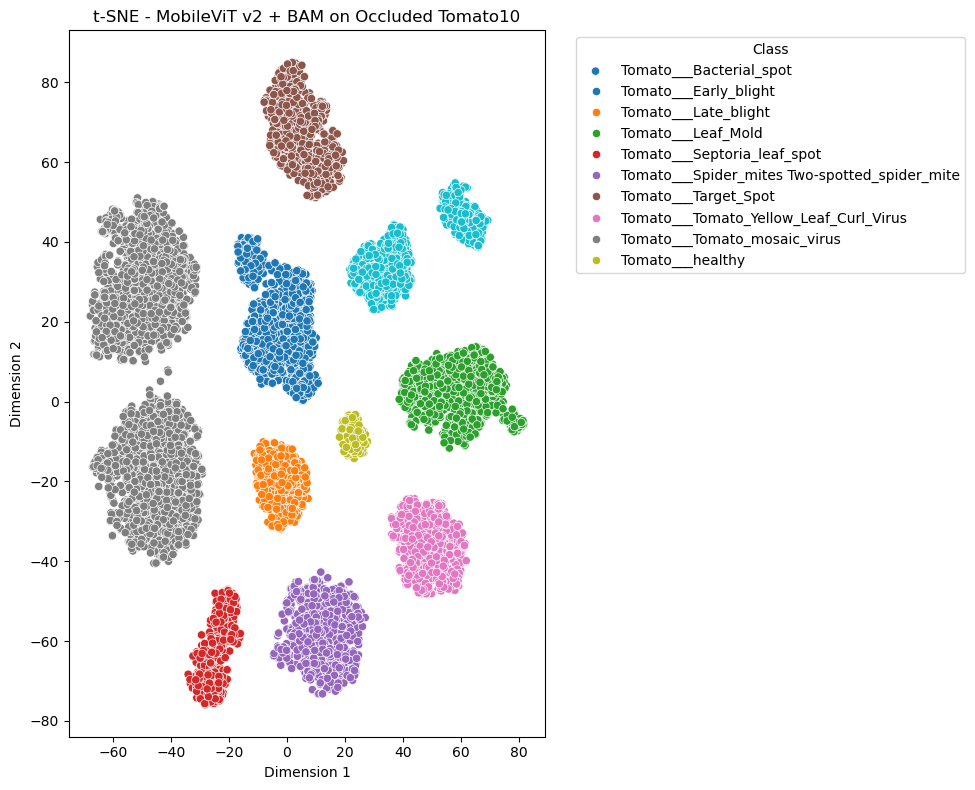

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F

model = MobileViTv2_BAM(num_classes=len(class_names)).to(device)
model.load_state_dict(torch.load("best_model_bam_mobilevitv2.pth"))
model.eval()

features = []
labels = []

with torch.no_grad():
    for inputs, targets in tqdm(val_loader, desc="Extracting features"):
        inputs = inputs.to(device)
        feats = model.backbone.forward_features(inputs)  # استخدم الطبقة الأخيرة من feature extractor
        pooled = F.adaptive_avg_pool2d(feats, 1).squeeze()
        features.append(pooled.cpu().numpy())
        labels.extend(targets.numpy())

features = np.concatenate([
    f[np.newaxis, :] if f.ndim == 1 else f for f in features
], axis=0)


tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)


plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab10", len(class_names))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, legend='full', palette=palette)
plt.title("t-SNE - MobileViT v2 + BAM on Occluded Tomato10")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Class", labels=class_names, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("tsne_mobilevitv2_bam_occluded.png")
plt.show()
